### Import Model Architectures
Custom Torch Models need to be instantiated for evaluation. The model_architectures.py file contains the model architectures so we can abstract it and focus only on the evaluations.

In [1]:
from model_architectures import *
import torchvision
import model_architectures
from attacks import * 
# Print available classes to verify our model architectures were imported
print(dir(model_architectures))

Using device: cuda


C:\Users\Sai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
['BasicBlock', 'DataLoader', 'F', 'Load', 'ResNetCIFAR', 'ResNetMNIST', 'ResnetSVHN', 'TensorDataset', 'Tester', 'Visualizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cifar_directory', 'conv3x3', 'current_directory', 'device', 'mnist_directory', 'nn', 'np', 'os', 'pd', 'pickle', 'plt', 'scipy', 'svhn_directory', 'torch']


### Loading the Model Weights
Using our model artifacts we load the weights back into the model so we have our pre-trained models to test our perturbations against.

In [2]:
mnist_resnet_model = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=True).to(device)
cifar_resnet_model = ResNetCIFAR(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)
svhn_resnet_model = ResnetSVHN(BasicBlock, [2, 2, 2, 2], num_classes=10, grayscale=False).to(device)

#add map_location=torch.device('cpu') if running locally and ur not sai lol
device = 'cuda'
# mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth", map_location=torch.device(device)))
# cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth", map_location=torch.device(device)))
# svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth",map_location=torch.device(device)))
mnist_resnet_model.load_state_dict(torch.load("artifacts/resnet18_mnist_model.pth"))
cifar_resnet_model.load_state_dict(torch.load("artifacts/resnet18_cifar_model.pth"))
svhn_resnet_model.load_state_dict(torch.load("artifacts/resnet18_svhn_model.pth"))


attack = "jsma"
mnist_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_mnist_model.pth"))
# cifar_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_cifar_model.pth"))
# svhn_resnet_model.load_state_dict(torch.load(f"artifacts/{attack}_augmented_resnet18_svhn_model.pth"))

<All keys matched successfully>

In [3]:
# Set models to evaluation mode
mnist_resnet_model.eval()
cifar_resnet_model.eval()
svhn_resnet_model.eval()

ResnetSVHN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [4]:
loader = Load()
mnist_test_images, mnist_test_labels = loader.load_mnist_test_images()
cifar10_test_images, cifar10_test_labels = loader.load_cifar10_test_images()
svhn_test_images, svhn_test_labels = loader.load_svhn_test_images()

In [5]:
test_loader_mnist = loader.convert_mnist_numpy_to_tensor(mnist_test_images[:256], mnist_test_labels[:256])
test_loader_cifar10 = loader.convert_cifar10_numpy_to_tensor(cifar10_test_images[:256], cifar10_test_labels[:256])
test_loader_svhn = loader.convert_svhn_numpy_to_tensor(svhn_test_images[:256], svhn_test_labels[:256])
tester = Tester()

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [7]:
print("Attack Image & Predicted Label")
viz = Visualizer()


def test_jsma(model, test_loader, theta = 0.1):
    model.eval()

    pred_list = []
    correct = 0
    total = 0
    adv_examples = []

    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        for image, label in zip(images, labels):
            image = image.unsqueeze(0)
            label = label.unsqueeze(0)

            output, _ = model(image)

            # print(outputs)

            _, init_pred = torch.max(output.data, 1)
            
            if not torch.equal(init_pred, label):
                total +=1 
                continue 
            
            target = torch.topk(output,2).indices[0][1].item()
            advimages = jsma_attack(model, image, target, 10, theta = theta)
            output_adv, _ = model(advimages)
            
            _, prediction_adv = torch.max(output_adv.data, 1)

            if torch.equal(prediction_adv, label):
                correct += 1
            else:
                adv_ex = advimages.squeeze().detach().cpu().numpy()

                adv_examples.append( (init_pred.item(), prediction_adv.item(), adv_ex) )
                pred_list.append(prediction_adv)
                    
                        
            total +=1 
            print(correct, "/", total)  
            # if (total>0):
            #     break
            
    print('Accuracy of test text: %f %%' % ((float(correct) / total) * 100))
    return adv_examples


Attack Image & Predicted Label


In [8]:
adv_examples = test_jsma(mnist_resnet_model, test_loader_mnist, theta = 0.025)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 21
0 / 22
0 / 23
0 / 24
0 / 25
0 / 26
0 / 27
0 / 28
0 / 29
0 / 30
0 / 31
0 / 32
0 / 33
0 / 34
0 / 35
0 / 36
0 / 37
0 / 38
0 / 39
0 / 40
0 / 41
0 / 42
0 / 43
0 / 44
0 / 45
0 / 46
0 / 47
0 / 48
0 / 49
0 / 50
0 / 51
0 / 52
0 / 53
0 / 54
0 / 55
0 / 56
0 / 57
0 / 58
0 / 59
0 / 60
0 / 61
0 / 62
0 / 63
0 / 64
0 / 65
0 / 66
0 / 67
0 / 68
0 / 69
0 / 70
0 / 71
0 / 72
0 / 73
0 / 74
0 / 75
0 / 76
0 / 77
0 / 78
0 / 79
0 / 80
0 / 81
0 / 82
0 / 83
0 / 84
0 / 85
0 / 86
0 / 87
0 / 88
0 / 89
0 / 90
0 / 91
0 / 92
0 / 93
0 / 94
0 / 95
0 / 96
0 / 97
0 / 98
0 / 99
0 / 100
0 / 101
0 / 102
0 / 103
0 / 104
0 / 105
0 / 106
0 / 107
0 / 108
0 / 109
0 / 110
0 / 111
0 / 112
0 / 113
0 / 114
0 / 115
0 / 117
0 / 118
0 / 119
0 / 120
0 / 121
0 / 122
0 / 123
0 / 124
0 / 125
0 / 126
0 / 127
0 / 128
0 / 129
0 / 130
0 / 131
0 / 132
0 / 133
0 / 134
0 / 135
0 / 136
0 / 137
0 / 138
0 / 139
0 / 

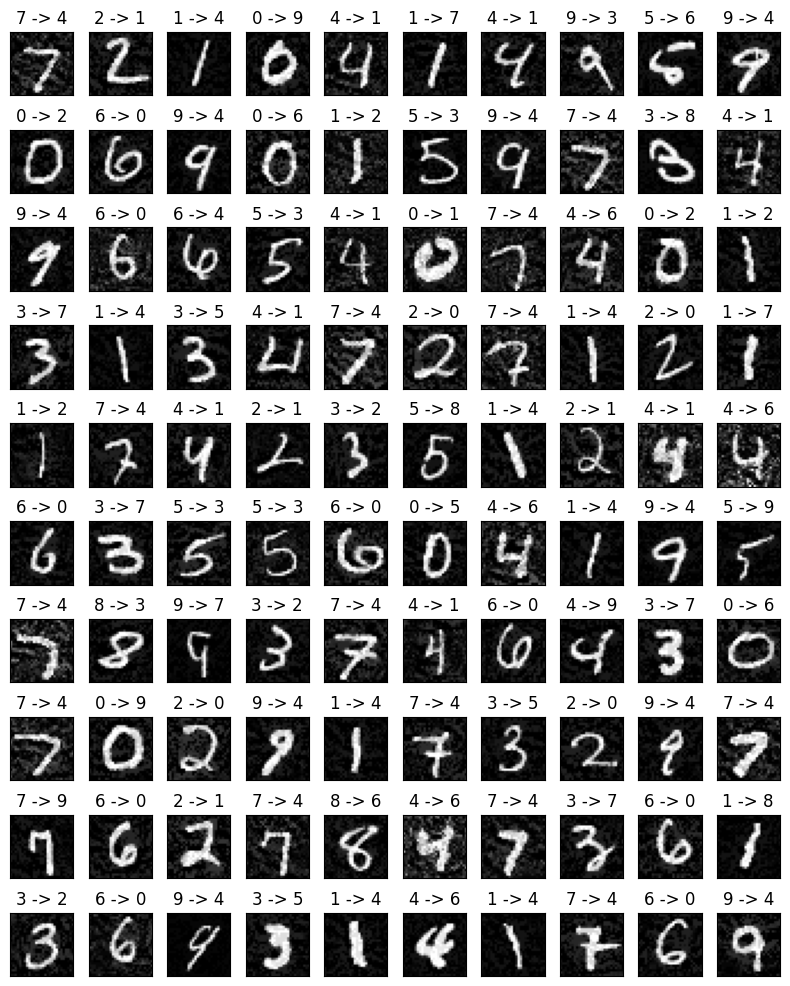

: 

In [11]:
# num_cols = len(adv_examples)
# print(num_cols)

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    plt.title(f"{orig} -> {adv}")
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
adv_examples = test_jsma(cifar_resnet_model, test_loader_cifar10, theta = 0.000625)

0 / 1
0 / 2
0 / 4
0 / 6
0 / 7
0 / 8
0 / 10
0 / 11
0 / 12
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 22
0 / 24
0 / 26
0 / 27
0 / 28
0 / 29
0 / 30
0 / 31
0 / 33
0 / 34
0 / 35
0 / 38
0 / 39
0 / 40
0 / 41
1 / 42
1 / 44
1 / 45
1 / 46
1 / 47
1 / 49
1 / 50
1 / 51
1 / 52
1 / 54
1 / 55
1 / 56
1 / 57
1 / 61
1 / 63
1 / 64
1 / 65
1 / 66
1 / 67
1 / 68
1 / 71
1 / 72
1 / 73
1 / 74
1 / 75
1 / 76
1 / 78
1 / 79
1 / 80
1 / 81
1 / 83
1 / 84
1 / 85
1 / 87
1 / 89
1 / 90
1 / 91
1 / 93
1 / 94
1 / 95
1 / 96
1 / 97
1 / 98
1 / 99
1 / 100
1 / 101
1 / 102
1 / 103
1 / 105
1 / 106
1 / 108
1 / 109
1 / 110
1 / 111
1 / 112
1 / 114
1 / 116
1 / 117
1 / 118
1 / 121
1 / 122
1 / 123
1 / 124
1 / 125
1 / 127
1 / 128
1 / 131
1 / 132
1 / 133
1 / 134
1 / 135
1 / 136
1 / 137
1 / 138
1 / 139
1 / 141
1 / 142
1 / 143
1 / 144
1 / 145
1 / 146
1 / 147
1 / 150
1 / 151
1 / 152
1 / 153
1 / 154
1 / 155
1 / 156
1 / 157
1 / 158
1 / 160
1 / 162
1 / 163
1 / 164
1 / 166
1 / 167
1 / 168
1 / 171
1 / 172
1 / 174
1 / 175
1 / 176
1 / 177
1

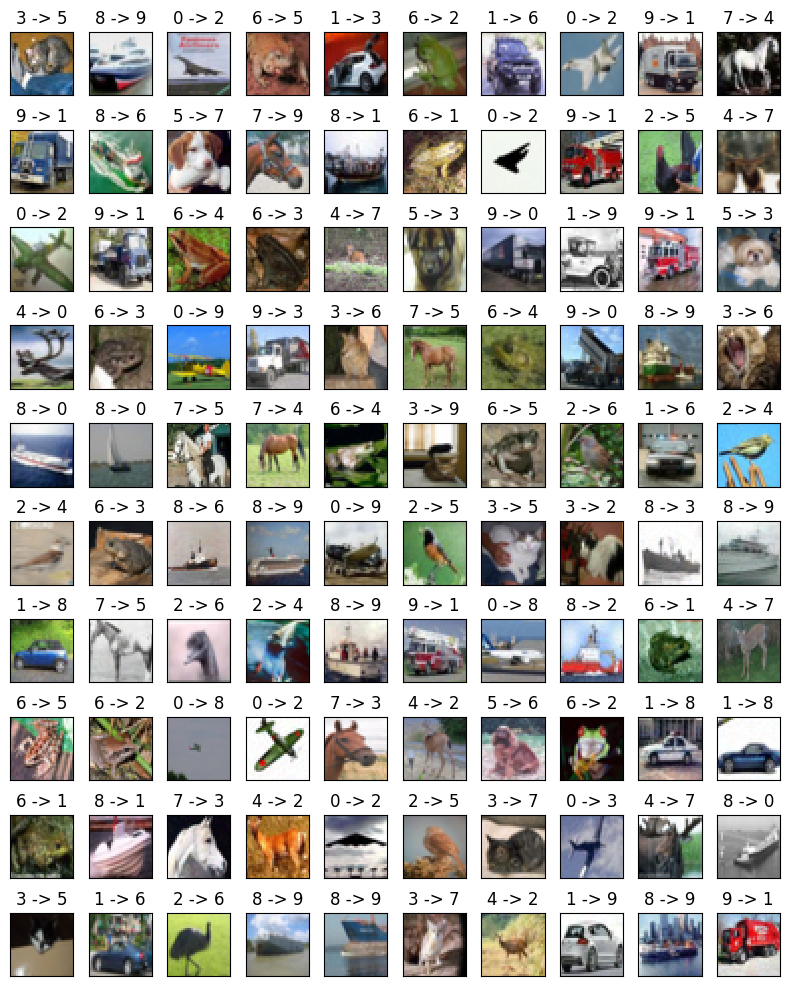

In [ ]:
label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    # ex = ex / 255 # Normalizing pixel values
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()

In [ ]:
adv_examples = test_jsma(svhn_resnet_model, test_loader_svhn, theta = 0.0025)

0 / 1
0 / 2
0 / 3
0 / 4
0 / 5
0 / 6
0 / 7
0 / 8
0 / 9
0 / 10
0 / 11
0 / 12
0 / 13
0 / 14
0 / 15
0 / 16
0 / 17
0 / 18
0 / 19
0 / 20
0 / 21
0 / 22
0 / 23
0 / 25
0 / 26
0 / 27
0 / 28
0 / 29
0 / 30
0 / 32
0 / 33
0 / 34
0 / 35
0 / 36
1 / 37
1 / 38
1 / 39
1 / 40
1 / 42
1 / 43
1 / 44
1 / 45
1 / 46
1 / 47
1 / 48
1 / 49
1 / 50
1 / 51
1 / 52
1 / 53
1 / 54
1 / 55
1 / 58
1 / 61
1 / 62
1 / 63
1 / 64
1 / 65
1 / 66
1 / 67
1 / 68
1 / 69
1 / 70
1 / 71
1 / 72
1 / 73
1 / 74
1 / 75
1 / 76
1 / 77
1 / 78
1 / 79
1 / 80
1 / 81
1 / 82
1 / 83
1 / 84
1 / 85
1 / 86
1 / 87
1 / 88
1 / 89
1 / 90
1 / 91
1 / 92
1 / 93
2 / 94
2 / 95
2 / 96
2 / 98
2 / 99
2 / 100
2 / 101
2 / 102
2 / 103
2 / 104
2 / 105
2 / 106
2 / 107
2 / 108
2 / 109
2 / 110
2 / 111
2 / 112
2 / 113
2 / 115
2 / 116
2 / 117
2 / 118
2 / 119
2 / 120
2 / 121
2 / 122
2 / 123
2 / 124
2 / 125
2 / 126
2 / 127
2 / 128
2 / 129
2 / 130
2 / 131
2 / 133
2 / 134
2 / 135
2 / 136
2 / 137
2 / 138
2 / 139
2 / 140
2 / 142
2 / 143
2 / 144
2 / 145
2 / 146
2 / 147
2 / 148
2 / 

[[[0.15401961 0.15794118 0.15794118 ... 0.15578432 0.15970589 0.15794118]
  [0.15794118 0.15794118 0.15794118 ... 0.15578432 0.16362746 0.15794118]
  [0.14651962 0.14009805 0.15044118 ... 0.16362746 0.16362746 0.15044118]
  ...
  [0.20142157 0.21284313 0.19500001 ... 0.17254902 0.16754903 0.15578432]
  [0.19107844 0.19500001 0.18715687 ... 0.16754903 0.1714706  0.16220589]
  [0.1932353  0.1832353  0.17539217 ... 0.16612746 0.16754903 0.16220589]]

 [[0.40142158 0.41034314 0.41284314 ... 0.395      0.40142158 0.37789217]
  [0.41284314 0.41284314 0.41284314 ... 0.395      0.39357844 0.38539216]
  [0.40676472 0.40284315 0.41068628 ... 0.39107844 0.38715687 0.37539217]
  ...
  [0.47166666 0.46558824 0.4577451  ... 0.4577451  0.45382354 0.44205883]
  [0.45882353 0.4577451  0.44990197 ... 0.45382354 0.44990197 0.43813726]
  [0.4534804  0.4459804  0.43813726 ... 0.44990197 0.4459804  0.43813726]]

 [[0.24029411 0.24421568 0.24813725 ... 0.23421569 0.24813725 0.22852941]
  [0.24421568 0.241715

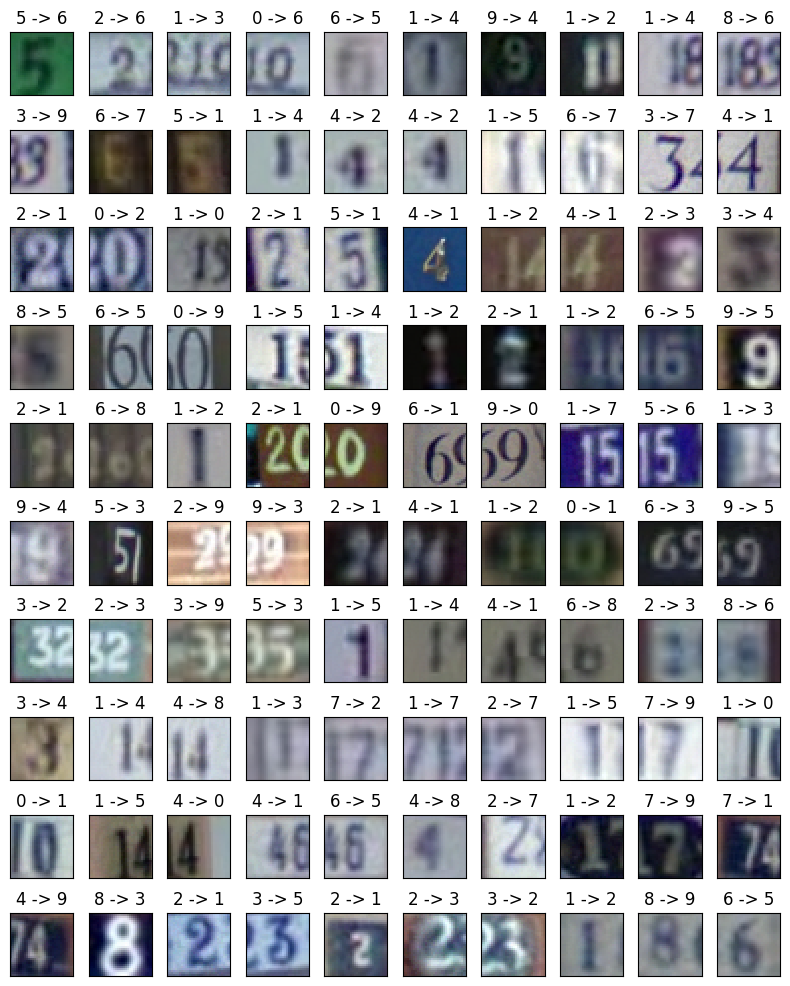

: 

In [ ]:
# Test visualizer with an image available in test data
viz = Visualizer()
label_mapping2 = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'
}

print(adv_examples[0][2])

plt.figure(figsize=(8, 10))
for j in range(100):
    plt.subplot(10, 10, j + 1)
    plt.xticks([], [])
    plt.yticks([], [])
    orig, adv, ex = adv_examples[j]
    ex = np.transpose(ex, (1, 2, 0))  # Changing shape to (32, 32, 3) for imshow
    # ex = ex / 255 # Normalizing pixel values
    plt.title(f"{orig.item()} -> {adv.item()}")
    plt.imshow(ex)
plt.tight_layout()
plt.show()